# Introduction

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import abc
import functools
import time

%matplotlib inline

## Modeling MDPs in TensorFlow

All classes defining MDPs must inherit from abstract class ```MDP```.

In [2]:
class MDP(metaclass=abc.ABCMeta):
    
    @abc.abstractproperty
    def action_size(self):
        return
    
    @abc.abstractproperty
    def state_size(self):
        return

    @abc.abstractmethod
    def transition(self, state, action):
        return

    @abc.abstractmethod
    def reward(self, state, action):
        return


### Navigation in 2D grid with deceleration zone at the center

In [3]:
class Navigation(MDP):

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

        # grid constants
        self.__size = tf.constant(self.size, dtype=tf.float32)
        self.__center = tf.constant(self.center, dtype=tf.float32)
        self.__goal = tf.constant(self.goal, dtype=tf.float32)

        # numerical constants
        self.__0_00 = tf.constant(0.00, dtype=tf.float32)
        self.__1_00 = tf.constant(1.00, dtype=tf.float32)
        self.__2_00 = tf.constant(2.00, dtype=tf.float32)
        self.__8_00 = tf.constant(8.00, dtype=tf.float32)
        self.__decay = tf.constant(self.decay, dtype=tf.float32)

    @property
    def action_size(self):
        return self.ndim
    
    @property
    def state_size(self):
        return self.ndim
        
    def transition(self, state, action, noise):

        # rotation angle (in degrees)
        velocity = tf.norm(action, axis=1, keep_dims=True)
        
        # f(x) = 1 / (1 + exp(-8(x-1)))
        atenuation = self.__1_00 / (self.__1_00 + tf.exp(-self.__8_00 * (velocity - self.__1_00)))
        max_theta = 20  # degrees
        theta =  max_theta * atenuation

        # apply rotation noise
        cos, sin = tf.cos(theta * np.pi / 180 * noise), tf.sin(theta * np.pi / 180 * noise)
        
        noise_matrix = tf.stack([cos, -sin, sin, cos], axis=1)
        noise_matrix = tf.reshape(noise_matrix, [-1, 2, 2])
        noisy_action = tf.matmul(noise_matrix, tf.reshape(action, [-1, 2, 1]))
        noisy_action = tf.reshape(noisy_action, [-1, 2])
        
        # distance to center of grid
        d = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center), 1, keep_dims=True))

        # deceleration_factor
        deceleration = self.__2_00 / (self.__1_00 + tf.exp(-self.__decay * d)) - self.__1_00
        # deceleration = self.__1_00
        
        # next position
        next_state = state + deceleration * noisy_action
        next_state = tf.clip_by_value(next_state, self.__0_00, self.__size)

        return next_state

    def reward(self, state, action):
        # norm L-1 (manhattan distance)
        # return -tf.reduce_sum(tf.abs(state - self.__goal), 1, keep_dims=True)
        
        # norm L-2 (euclidean distance)
        return -tf.sqrt(tf.reduce_sum(tf.square(state - self.__goal), 1, keep_dims=True))

## Encoding an MDP as a Recurrent Neural Net

In [4]:
def policy_network(layers, state, limits=1.0):
    assert(layers[0] == state.shape[1])

    with tf.variable_scope('policy'):
        
        # hidden layers
        outputs = state
        for i, n_h in enumerate(layers[1:]):
            if i != len(layers)-2:
                activation = tf.nn.relu
            else:
                activation = tf.nn.tanh

            outputs = tf.layers.dense(outputs,
                                      units=n_h,
                                      activation=activation,
                                      kernel_initializer=tf.glorot_normal_initializer(),
                                      name="layer"+str(i+1))

        # add action limits over last tanh layer
        action = tf.constant(limits) * outputs

    # print(tf.get_default_graph().get_collection('variables'))
    
    return action

In [5]:
class MDP_RNNCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy

    @property
    def state_size(self):
        return mdp.state_size

    @property
    def output_size(self):
        return mdp.state_size + mdp.action_size + 1

    def __call__(self, inputs, state, scope=None):
        # add policy network
        action = self.policy(state)

        # add MDP components to the RNN cell output
        noise = inputs
        next_state =  self.mdp.transition(state, action, noise)
        reward = self.mdp.reward(next_state, action)

        return tf.concat([reward, next_state, action], 1), next_state


In [6]:
class MDP_RNN(object):
    
    def __init__(self, mdp, policy, batch_size=1):
        self.cell = MDP_RNNCell(mdp, policy)
        self.batch_size = batch_size
    
    def unroll(self, inputs, initial_state):
        # dynamic time unrolling
        outputs, final_state = tf.nn.dynamic_rnn(
            self.cell,
            inputs,
            initial_state=initial_state,
            dtype=tf.float32)

        # gather reward, state and action series
        outputs = tf.unstack(outputs, axis=2)
        max_time = int(inputs.shape[1])

        reward_series = tf.reshape(outputs[0], [-1, max_time, 1])
        state_series  = tf.stack(outputs[1:3], axis=2)
        action_series = tf.stack(outputs[3:5], axis=2)
        
        return reward_series, state_series, action_series, final_state


## Defining the action optimizer

In [7]:
class PolicyOptimizer(object):
    
    def __init__(self, loss, total, learning_rate, size, ratio=1.0):
        self.loss = loss
        self.total = total
        
        # noise size
        self.size = size
        self.noise_size = (int(ratio*size[0]), size[1], 1)

        # optimization hyperparameters
        self.learning_rate = learning_rate

        # backprop via RMSProp
        self.train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
        
        # global initializer
        self.init_op = tf.global_variables_initializer()

    def run(self, sess, epoch=100, show_progress=True):
        # initialize variables
        sess.run(self.init_op)
        
        losses = []
        for epoch_idx in range(epoch):
            # sample noise data from normal distribution
            # random_noise = np.random.normal(size=self.noise_size).astype(np.float32)
            
            # sample noise data from uniform distribution
            random_noise = np.random.uniform(low=-1.0, high=1.0, size=self.noise_size).astype(np.float32)
            
            # no noise at all...
            shape = (self.size[0] - self.noise_size[0], self.size[1], 1)
            zero_noise = np.zeros(shape=shape).astype(np.float32)
            
            # noise
            inputs_data = np.concatenate([random_noise, zero_noise], axis=0)

            # backprop and update weights
            _, loss, total = sess.run([self.train_step, self.loss, self.total], feed_dict={inputs: inputs_data})

            # store and show loss information
            losses.append(loss)
            if show_progress:
                print('Epoch {0:5}: loss = {1}\r'.format(epoch_idx, loss), end='')
        print()
    
        variables = sess.run({ var.name: var for var in tf.trainable_variables() })

        return losses, total, variables


## Putting all together

### Instantiate the MDP model

In [8]:
params = {
    'ndim': 2,
    'size': (10.0, 10.0),
    'initial': (1.0, 5.0),
    'goal': (8.0, 5.0),
    'center': (5.0, 5.0),
    'decay': 2.0,
    'limits': (-1.0, 1.0)
}

# MDP model
mdp = Navigation(**params)

### Unroll the RNN model

In [9]:
def build_initial_states_grid(x_grid_size, y_grid_size):
    batch_size = x_grid_size * y_grid_size
    x_grid = np.linspace(0.0, params['size'][0], x_grid_size)
    y_grid = np.linspace(0.0, params['size'][1], y_grid_size)
    initial_states_grid = []
    for x in x_grid:
        for y in y_grid:
            initial_states_grid.append([x, y])
    return initial_states_grid, batch_size

# different initial state for each batch (mesh grid)
# grid_size = 100
# initial_states_grid, batch_size = build_initial_states_grid(grid_size, grid_size)
# initial_state = tf.constant(initial_states_grid)

# same initial state for each batch
batch_size = 10000
x_initial, y_initial = params['initial']
x_initial = tf.fill([batch_size], tf.constant(x_initial, tf.float32))
y_initial = tf.fill([batch_size], tf.constant(y_initial, tf.float32))
initial_state = tf.stack([x_initial, y_initial], axis=1)

# inputs (noise)
max_time = 9
inputs = tf.placeholder(tf.float32, shape=[None, max_time, 1], name="inputs")

# define policy network
layers = [mdp.state_size, 20, 5, mdp.action_size]
policy = functools.partial(policy_network, layers)

# unroll MDP model
rnn = MDP_RNN(mdp, policy, batch_size)
rewards, states, actions, final_state = rnn.unroll(inputs, initial_state)

### Define the loss function

In [10]:
# loss based on total reward
total = tf.reduce_sum(rewards, 1)
loss  = tf.reduce_mean(tf.square(total))

### Train the Policy Network

In [11]:
def train(loss, total, batch_size=1000, max_time=10, epoch=200, learning_rate=0.01):
    # optimizer
    noise_ratio = 1.00
    optimizer = PolicyOptimizer(loss, total, learning_rate, (batch_size, max_time, 1), noise_ratio)
    
    # saver
    saver = tf.train.Saver()
    
    # initilize session
    start = time.time()
    with tf.Session() as sess:
        # optimize it, babe!
        losses, total_cost_per_batch, variables = optimizer.run(sess, epoch)
        
        # save model
        save_path = saver.save(sess, 'models/model.ckpt')
        print("Model saved in file: %s" % save_path)
        
    end = time.time()
    uptime = end - start
    print("Done in {0:.6f} sec".format(uptime))

    return losses, total_cost_per_batch, variables, uptime

In [12]:
# it's time to train...

# hyper-parameters
epoch=100
learning_rate = 0.005

losses, total_cost_per_batch, variables, uptime = train(loss, total, batch_size, max_time, epoch, learning_rate)

Epoch    99: loss = 664.99334716796885
Model saved in file: models/model.ckpt
Done in 23.078925 sec


## Evaluate Policy Network

In [13]:
tf.reset_default_graph()

grid_size = 10
initial_states_grid, batch_size = build_initial_states_grid(grid_size, grid_size)
initial_state = tf.constant(initial_states_grid)

with tf.variable_scope('rnn'):
    action = policy(initial_state)
    assert(initial_state.shape == action.shape)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'models/model.ckpt')
    actions = sess.run(action)

INFO:tensorflow:Restoring parameters from models/model.ckpt


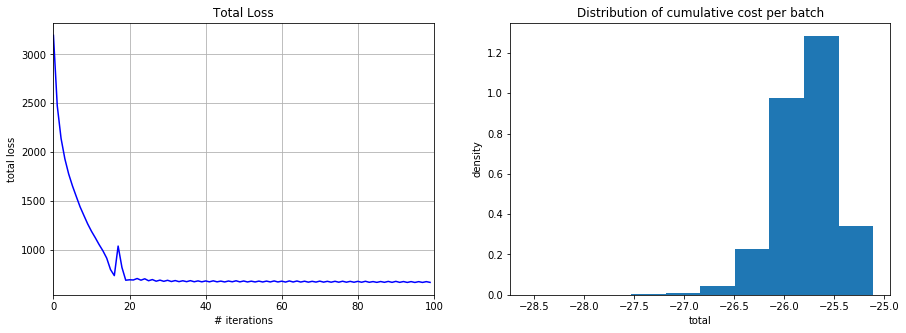

In [14]:
plt.figure(figsize=(15, 5))

# plotting losses
plt.subplot(121)
plt.plot(losses, 'b-')
plt.xlim(0, epoch)
plt.title('Total Loss')
plt.xlabel("# iterations")
plt.ylabel("total loss")
plt.grid()

# histogram of cumulative cost per batch
plt.subplot(122)
plt.hist(total_cost_per_batch, normed=True, histtype='stepfilled')
plt.title('Distribution of cumulative cost per batch')
plt.xlabel('total')
plt.ylabel('density')

In [15]:
def plot_policy(end, action_grid, actions, deceleration=True):
    plt.figure(figsize=(8, 8))
    
    # params
    xlim, ylim = params['size']
    xcenter, ycenter = params['center']
    
    # plot configuration
    plt.axis([0.0, xlim, 0.0, ylim])
    plt.axes().set_aspect('equal')
    plt.grid()
    plt.title("Policy", fontweight="bold", fontsize=16)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")

    if deceleration:
        npoints = 1000
        X, Y = np.meshgrid(np.linspace(0.0, xlim, npoints), np.linspace(0.0, ylim, npoints))
        D = np.sqrt((X - xcenter) ** 2 + (Y - ycenter) ** 2)
        Lambda = 2 / (1 + np.exp(-params['decay'] * D)) - 1.00

        ticks = np.arange(0.0, 1.01, 0.10)
        cp = plt.contourf(X, Y, Lambda, ticks, cmap=plt.cm.bone)
        cp = plt.contour(X, Y, Lambda, ticks, colors='black', linestyles='dashed')
        
    # action_grid
    initial_states_x = [ p[0] for p in action_grid ]
    initial_states_y = [ p[1] for p in action_grid ]
    plt.plot(initial_states_x, initial_states_y, 'g.')
 
    # actions
    plt.quiver(initial_states_x, initial_states_y, actions[:, 0], actions[:, 1],
               angles='xy', scale_units='xy', scale=1, color='dodgerblue', width=0.005,
               label='actions')

    # end
    plt.plot([end[0]], [end[1]], marker='X', markersize=15, color='crimson', label='goal')


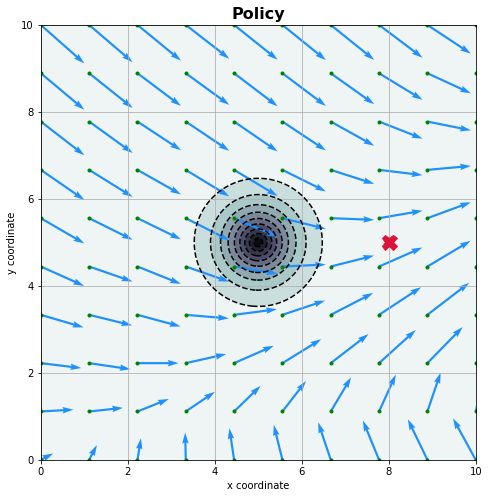

In [16]:
start, end = params['initial'], params['goal']
plot_policy(end, initial_states_grid, actions)

## Simulate policy

In [17]:
def simulate(series, batch_size=1, max_time=10):
    saver = tf.train.Saver()

    with tf.Session() as sess:
        # restore learned policy model
        saver.restore(sess, 'models/model.ckpt')

        # sample noise data
        inputs_data = np.random.normal(size=(batch_size, max_time, 1)).astype(np.float32)

        # simulate MDP trajectories
        result = sess.run(series, feed_dict={inputs: inputs_data})
    return result

In [18]:
tf.reset_default_graph()

max_time = 9
batch_size = 3

# initial states for simulation
x_start, y_start = params['initial']
x_initial = tf.fill([batch_size], tf.constant(x_start, tf.float32))
y_initial = tf.fill([batch_size], tf.constant(y_start, tf.float32))
initial_state = tf.stack([x_initial, y_initial], axis=1)
delta = [-3.0, -1.5, 1.5, 3.0]
for delta_y in delta:
    x_initial = tf.fill([batch_size], tf.constant(x_start, tf.float32))
    y_initial = tf.fill([batch_size], tf.constant(y_start + delta_y, tf.float32))
    initial_state = tf.concat([initial_state, tf.stack([x_initial, y_initial], axis=1)], axis=0)

batch_size = initial_state.shape[0]

# inputs
inputs = tf.placeholder(tf.float32, shape=[batch_size, max_time, 1], name="inputs")

# MDP model
mdp = Navigation(**params)

# unroll MDP model
rnn = MDP_RNN(mdp, policy, batch_size)
rewards, states, actions, final_state = rnn.unroll(inputs, initial_state)

# simulate
rewards, states, actions = simulate([rewards, states, actions], batch_size, max_time)


INFO:tensorflow:Restoring parameters from models/model.ckpt


In [19]:
def plot_simulation(ax, start, end, s_series, a_series, deceleration=True, initial=False):
    # params
    xlim, ylim = params['size']
    xcenter, ycenter = params['center']
    
    # plot configuration
    ax.axis([0.0, xlim, 0.0, ylim])
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel("x coordinate")
    ax.set_ylabel("y coordinate")

    if deceleration:
        npoints = 1000
        X, Y = np.meshgrid(np.linspace(0.0, xlim, npoints), np.linspace(0.0, ylim, npoints))
        D = np.sqrt((X - xcenter) ** 2 + (Y - ycenter) ** 2)
        Lambda = 2 / (1 + np.exp(-params['decay'] * D)) - 1.00
        ticks = np.arange(0.0, 1.01, 0.10)
        cp = ax.contourf(X, Y, Lambda, ticks, cmap=plt.cm.bone)
        cp = ax.contour(X, Y, Lambda, ticks, colors='black', linestyles='dashed')

    if initial:
        initial_states_x = [ p[0] for p in initial_states_grid ]
        initial_states_y = [ p[1] for p in initial_states_grid ]
        ax.plot(initial_states_x, initial_states_y, 'gx')

    # actions
    positions = np.concatenate([[start], s_series])
    ax.quiver(positions[:-1, 0], positions[:-1, 1], a_series[:, 0], a_series[:, 1],
              angles='xy', scale_units='xy', scale=1, color='dodgerblue', width=0.005,
              label='actions')

    # states
    ax.plot(positions[:, 0], positions[:, 1], '-', marker='o', color='darkblue', markersize=8, label='states')

    # start and end
    ax.plot([start[0]], [start[1]], marker='X', markersize=15, color='limegreen', label='initial')
    ax.plot([end[0]], [end[1]], marker='X', markersize=15, color='crimson', label='goal')


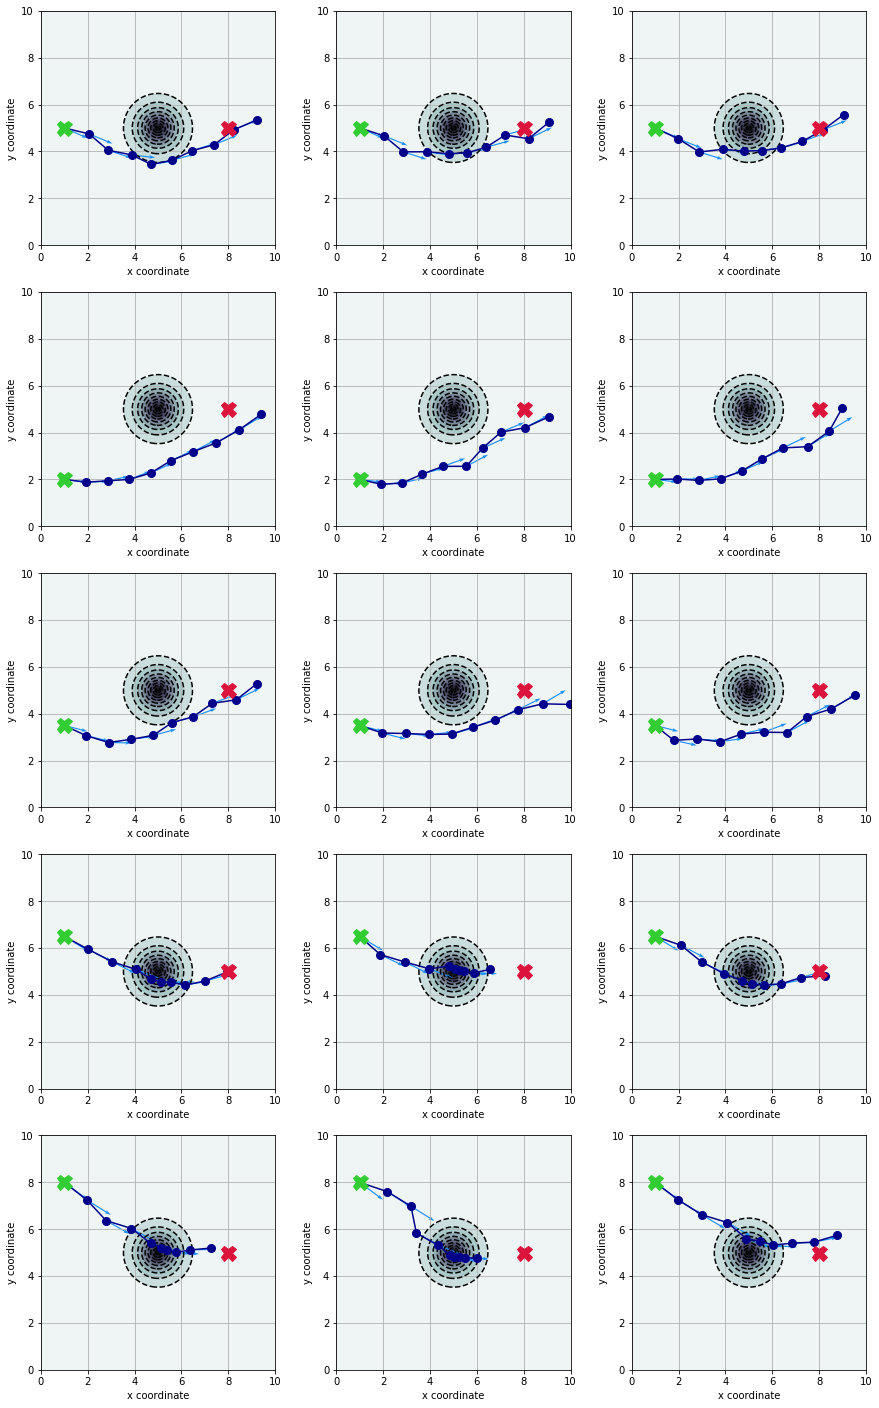

In [20]:
start, end = params['initial'], params['goal']
fig = plt.figure(figsize=(15, 25))
num_plots = int(initial_state.shape[0])
deltas = [0] + delta
rows = len(deltas)
cols = num_plots // len(deltas)
for i in range(num_plots):
    ax = fig.add_subplot(len(deltas),num_plots/len(deltas),i+1)
    idx = i//cols
    start = (params['initial'][0], params['initial'][1] + deltas[idx])
    plot_simulation(ax, start, end, states[i], actions[i])